In [3]:
datasetName = 'skin_FetalSkin2_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/skin_FetalSkin2_Guo2020")

In [4]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [5]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalSkin_2.CTGAAAGAGATCACAATA,FetalSkin_2.ACACCCTAGTCGCAACAA,FetalSkin_2.GATCTTCACAAGGCCCTC,FetalSkin_2.ACGAGCTATTGTATACAG,FetalSkin_2.TGATCATTGGACTATTGT
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A2M,0,2,0,0,3
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
FetalSkin_2.CTGAAAGAGATCACAATA,skin,FetalSkin,FetalSkin,normal,Donor17,female,7 weeks old
FetalSkin_2.ACACCCTAGTCGCAACAA,skin,FetalSkin,FetalSkin,normal,Donor17,female,7 weeks old
FetalSkin_2.GATCTTCACAAGGCCCTC,skin,FetalSkin,FetalSkin,normal,Donor17,female,7 weeks old
FetalSkin_2.ACGAGCTATTGTATACAG,skin,FetalSkin,FetalSkin,normal,Donor17,female,7 weeks old
FetalSkin_2.TGATCATTGGACTATTGT,skin,FetalSkin,FetalSkin,normal,Donor17,female,7 weeks old


[1] <NA>                                <NA>                               
[3] Erythroid progenitor cell (RP high) Erythroid progenitor cell (RP high)
[5] Endothelial cell                   
28 Levels: Antigen presenting cell (RPS high) B cell Basal cell ... T cell

In [6]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


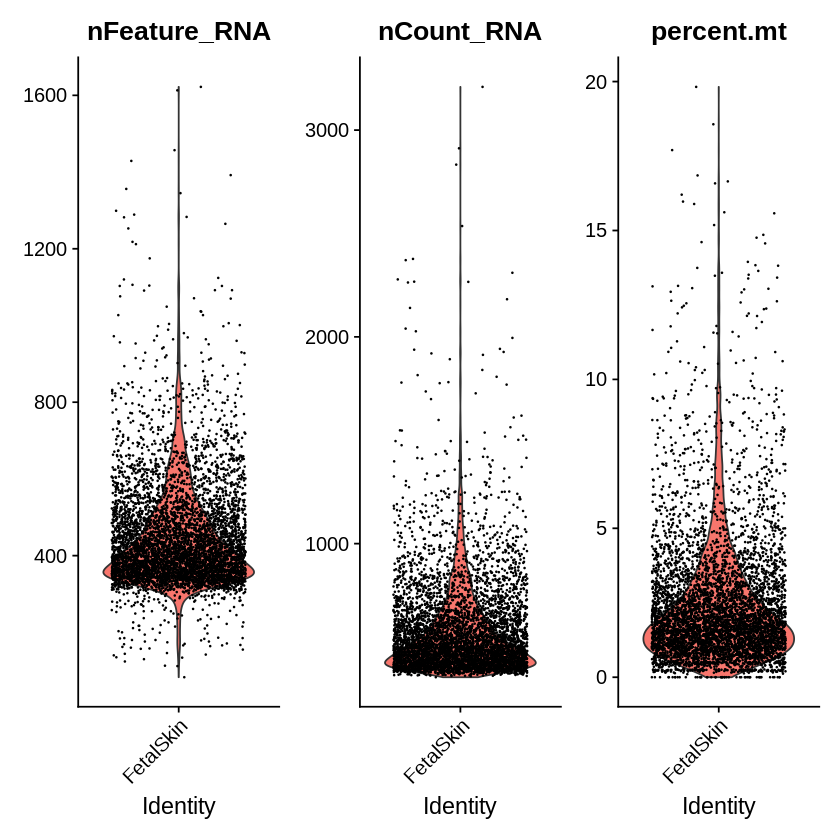

In [7]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [8]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 10
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [9]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [10]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  SRGN, CCL3, CCL3L3, CCL4, RNASE1, PLEK, IL1RN, CCL4L2, SPP1, LAPTM5 
	   C1QA, IL1B, LCP1, FCGR2A, FOLR2, CD163, FCER1G, CD74, AIF1, CXCL8 
	   CD14, BCL2A1, TYROBP, LYVE1, SAMSN1, FTL, HMOX1, HLA-B, TNFRSF1B, MRC1 
Negative:  COL1A1, COL3A1, COL1A2, LUM, DCN, SPARC, POSTN, CYR61, CTGF, LOX 
	   SFRP2, OGN, PENK, COL5A1, MEST, GLT8D2, NOV, SFRP4, PCOLCE, FN1 
	   CCL2, ISLR, ELN, PRSS23, PLAC9, DLK1, FBN1, TNC, FBLN5, CXCL14 
PC_ 2 
Positive:  COL1A1, COL1A2, COL3A1, SPARC, DCN, LUM, POSTN, LOX, CTGF, OGN 
	   SFRP4, COL5A1, SFRP2, THBS1, GLT8D2, FBN1, NOV, TNC, MFAP5, PRSS23 
	   CXCL1, DLK1, CYR61, PCOLCE, PLAC9, FN1, PENK, SERPINE1, ELN, KERA 
Negative:  TYRP1, PMEL, MLANA, TRPM1, DCT, QPCT, EDNRB, BCAN, TYR, CHCHD6 
	   PTTG1, SLC25A5, GPNMB, CA14, TFAP2A, PAX3, NSG1, SNCA, STX7, RAB38 
	   HMGB2, UBE2C, NUSAP1, S100B, PTGDS, C3orf79, IGFBP7, UBB, GPR143, CCNB1 
PC_ 3 
Positive:  CLDN5, TM4SF1, CDH5, SDPR, PECAM1, PLVAP, ECSCR, VWF, SELE, IGFBP7 
	   FLT1, S100A16

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


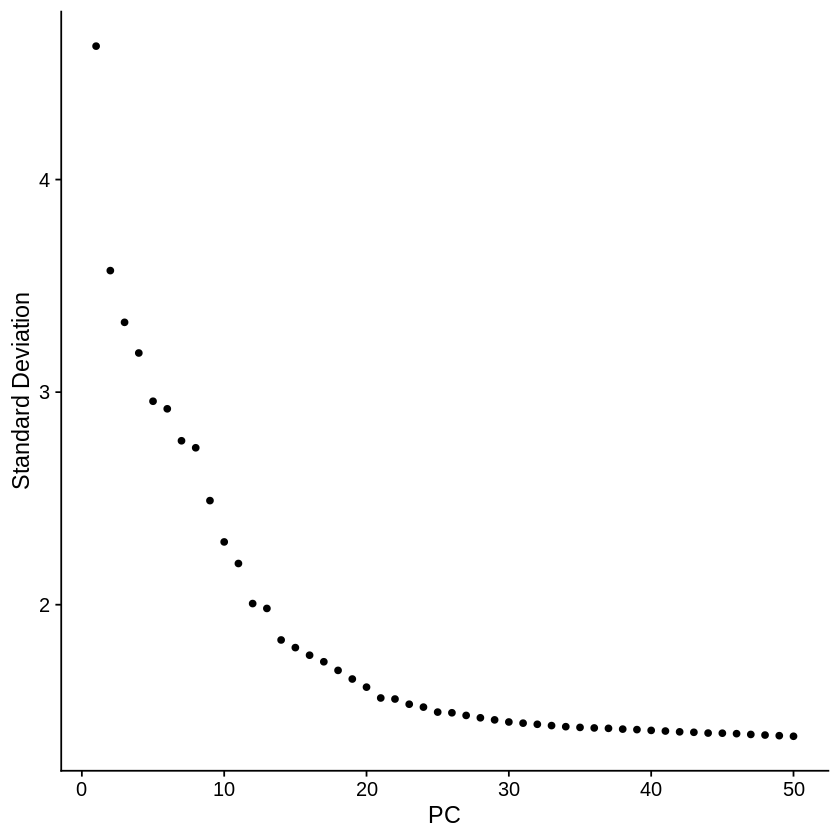

In [11]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [12]:
dev.off()
pcDim = 15 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
07:16:00 UMAP embedding parameters a = 0.9922 b = 1.112

07:16:00 Read 5382 rows and found 15 numeric columns

07:16:00 Using Annoy for neighbor search, n_neighbors = 30

07:16:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:16:00 Writing NN index file to temp file /tmp/RtmpOy8PTt/file64572d5a40f

07:16:00 Searching Annoy index using 1 thread, search_k = 3000

07:16:02 Annoy recall = 100%

07:16:02 Commencing smooth kNN distance calibration using 1 thread

07:16:03 Initializing from

In [13]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5382
Number of edges: 184513

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8485
Number of communities: 13
Elapsed time: 0 seconds


07:16:19 UMAP embedding parameters a = 0.9922 b = 1.112

07:16:19 Read 5382 rows and found 15 numeric columns

07:16:19 Using Annoy for neighbor search, n_neighbors = 30

07:16:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:16:20 Writing NN index file to temp file /tmp/RtmpOy8PTt/file645555b8404

07:16:20 Searching Annoy index using 1 thread, search_k = 3000

07:16:22 Annoy recall = 100%

07:16:22 Commencing smooth kNN distance calibration using 1 thread

07:16:22 Initializing from normalized Laplacian + noise

07:16:23 Commencing optimization for 500 epochs, with 234692 positive edges

07:16:36 Optimization finished



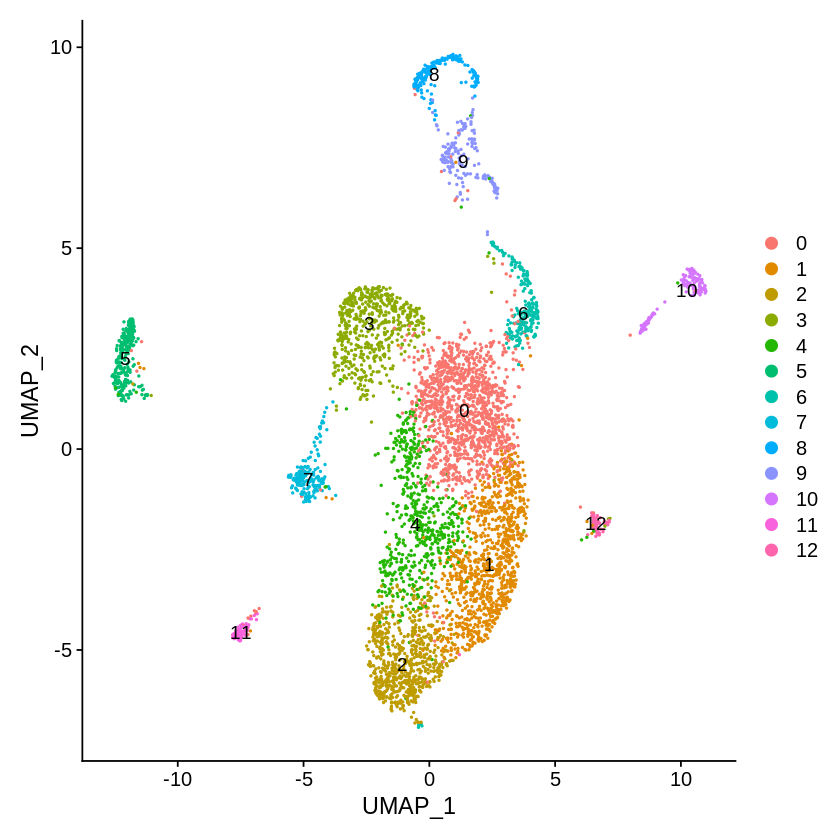

In [14]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [13]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

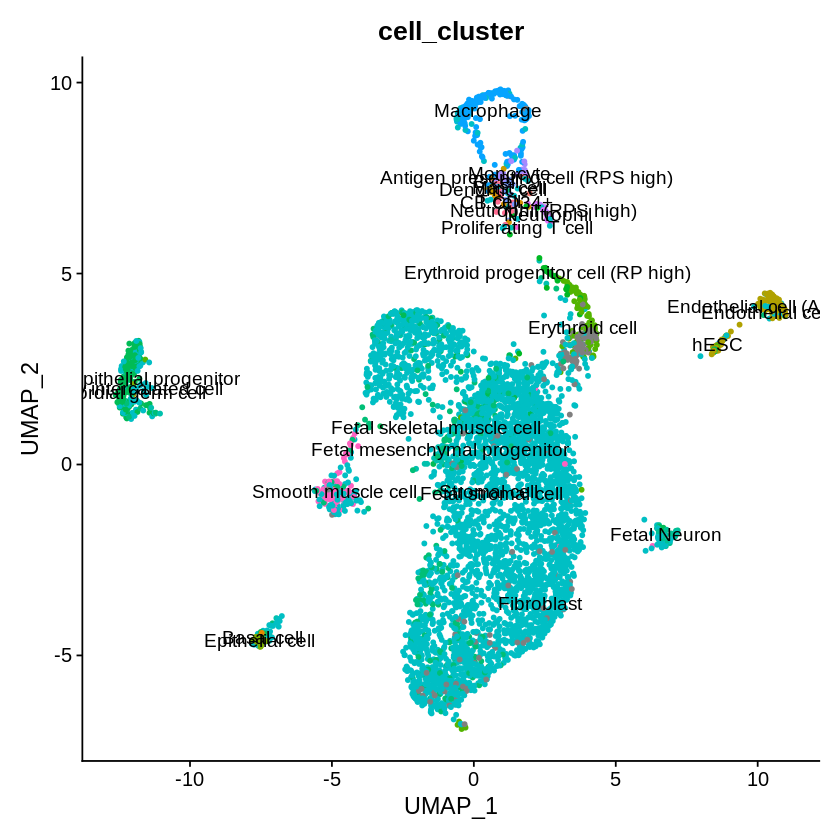

In [19]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [21]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [22]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



In [16]:
# 还没做annotation
new.cluster.ids <- c('Unknown', 'Skin-Connective tissue-Mesenchymal cell-SERPINE1',  'Skin-Connective tissue-Mesenchymal cell-SERPINE1', 
                     'Skin-Connective tissue-Fibroblast-SFRP4', 'Skin-Proliferating cell-TOP2A', 'Skin-Epithelial tissue-Melanocyte-TYRP1',
                    'Skin-Connective tissue-Erythroid cell-AHSP', 'Skin-Connective tissue-Stromal cell-ACTA2', 'Skin-Connective tissue-Macrophage-CD36',
                    'Skin-Connective tissue-Neutrophil-CD74', 'Skin-Epithelial tissue-Endothelial cell-SELE CLDN5', 'Skin-Epithelial tissue-Keratinocyte-KRT17',
                     'Skin-Epithelial tissue-Melanocyte-GFRA3')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

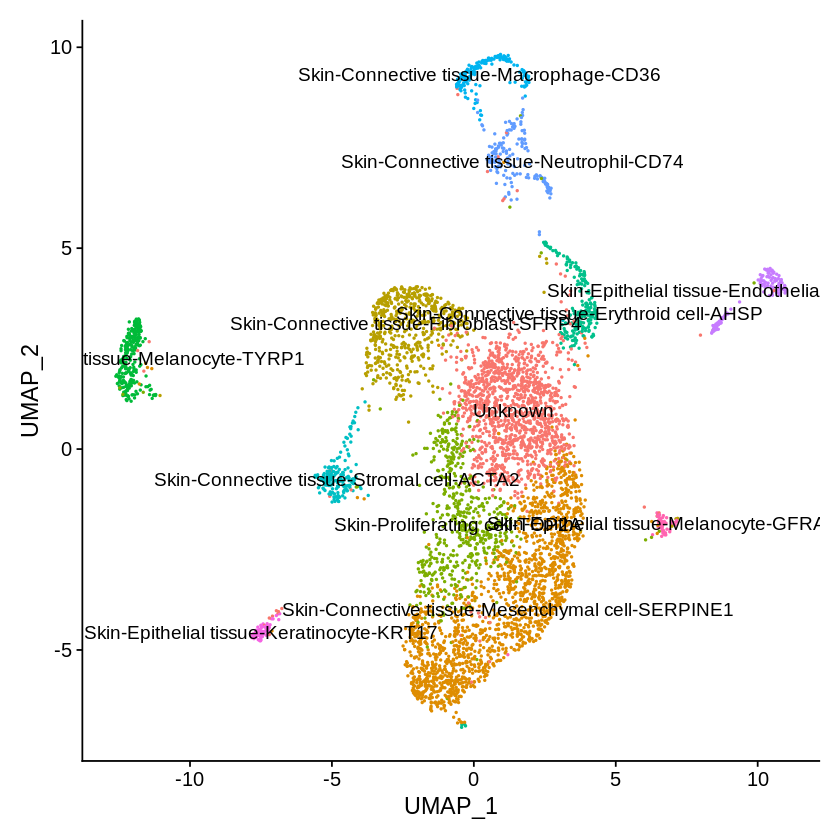

In [17]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [19]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [20]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))